# Visualize the Activation of a conv. net. 

Try to get conv net > 90% accuracy. 

Follow lession [16](https://course.fast.ai/Lessons/lesson16.html) and [17](https://course.fast.ai/Lessons/lesson17.html) from fast.ai to learn a bag of tricks. The plotted activation helps understand inner states of the model. 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
import random
import numpy as np

In [2]:
def set_seed(seed, deterministic=False):
    torch.use_deterministic_algorithms(deterministic)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

In [3]:
class ConvNet(torch.nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 4, 3)
        self.conv2 = torch.nn.Conv2d(4, 8, 3, stride=2)
        self.conv3 = torch.nn.Conv2d(8, 16, 3, stride=3)
        self.fc = torch.nn.Linear(256, 10)
        self.relu = torch.nn.ReLU()

        # kaiming init
        torch.nn.init.kaiming_normal_(self.conv1.weight, nonlinearity='relu')
        torch.nn.init.kaiming_normal_(self.conv2.weight, nonlinearity='relu')
        torch.nn.init.kaiming_normal_(self.conv3.weight, nonlinearity='relu')
        torch.nn.init.kaiming_normal_(self.fc.weight, nonlinearity='relu')

        # track means over time
        self.means = [[] for _ in range(4)]
        # track stds over time
        self.stds = [[] for _ in range(4)]
    
    def forward(self, x):
        # x: b x 1 x 28 x 28
        b = x.shape[0]
        self.track(0, x)
        # b x 4 x 26 x 26
        x = self.relu(self.conv1(x))
        self.track(1, x)
        # b x 8 x 12 x 12
        x = self.relu(self.conv2(x))
        self.track(2, x)
        # b x 16 x 4 x 4
        x = self.relu(self.conv3(x))
        self.track(3, x)
        # b x 256
        x = x.view((b, -1))
        # b x 10
        x = self.fc(x)
        return x

    def track(self, i, x):
        self.means[i].append(x.mean().item())
        self.stds[i].append(x.std().item())

In [4]:
import torchvision

t = torch.rand((1, 4, 4))
torchvision.transforms.functional.normalize(t, 0, 1)

tensor([[[0.8136, 0.0301, 0.6324, 0.0318],
         [0.4898, 0.5961, 0.6261, 0.6594],
         [0.4333, 0.2775, 0.7736, 0.5315],
         [0.1642, 0.9723, 0.0411, 0.4401]]])

In [5]:
def get_data_loader(batch_size):
    # Transformations applied to the dataset
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    # Load the training dataset
    trainset = torchvision.datasets.FashionMNIST(
        root='./data',
        train=True,
        download=True,
        transform=transform
    )

    # Create a data loader for the training dataset
    trainloader = torch.utils.data.DataLoader(
        trainset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
    )

    # Load the testing dataset
    testset = torchvision.datasets.FashionMNIST(
        root='./data',
        train=False,
        download=True,
        transform=transform,
    )

    # Create a data loader for the testing dataset
    testloader = torch.utils.data.DataLoader(
        testset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
    )

    return (trainloader, testloader)

In [6]:
def train(model, criterion, optimizer, trainloader, testloader, epoch=5):
    vis_losses = []
    vis_accs = []

    fig, axes = plt.subplots(5, 2, figsize=(30, 20))

    for e in range(epoch):
        for batch_idx, (inputs, labels) in enumerate(trainloader): 
            # Clear gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # track loss
            vis_losses.append(loss.item())
            vis_accs.append((predicted == labels).sum().item())
            steps = list(range(len(vis_accs)))
            

            # plot in real time
            if batch_idx % 50 == 0:
                clear_output(wait=True)
                
                axes[0, 0].plot(steps, vis_accs)
                axes[0, 0].set_title('Accuracy')
                
                axes[0, 1].plot(steps, vis_losses)
                axes[0, 1].set_title('Loss Curve')

                axes[1, 0].plot(steps, model.means[0])
                axes[1, 0].set_title('Activation Means 0')

                axes[1, 1].plot(steps, model.stds[0])
                axes[1, 1].set_title('Activation Stds 0')

                axes[2, 0].plot(steps, model.means[1])
                axes[2, 0].set_title('Activation Means 1')

                axes[2, 1].plot(steps, model.stds[1])
                axes[2, 1].set_title('Activation Stds 1')

                axes[3, 0].plot(steps, model.means[2])
                axes[3, 0].set_title('Activation Means 2')

                axes[3, 1].plot(steps, model.stds[2])
                axes[3, 1].set_title('Activation Stds 1')

                axes[4, 0].plot(steps, model.means[3])
                axes[4, 0].set_title('Activation Means 3')

                axes[4, 1].plot(steps, model.stds[3])
                axes[4, 1].set_title('Activation Stds 1')

                display(fig)
        
        

KeyboardInterrupt: 

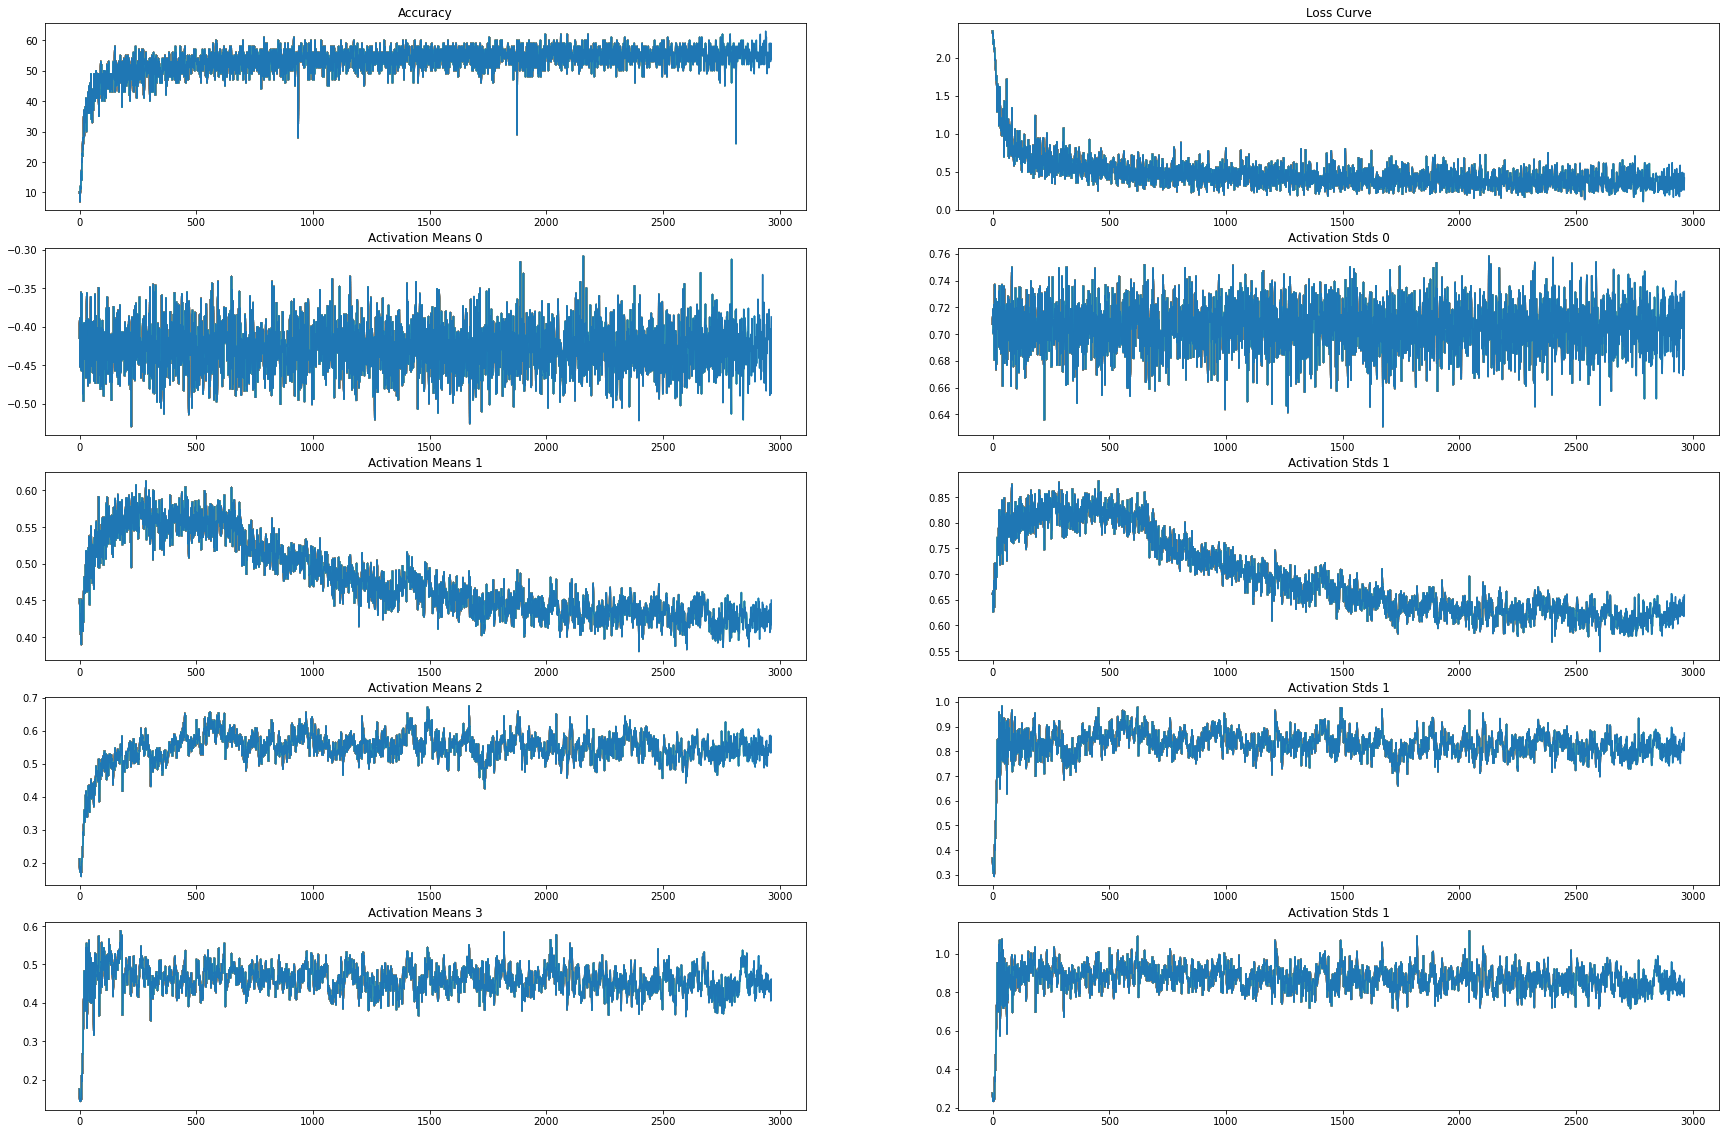

In [8]:
# Define the batch size for training
trainloader, testloader = get_data_loader(batch_size=64)

# Define the model
model = ConvNet()

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.1)

train(model, criterion, optimizer, trainloader, testloader, epoch=5)